In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [53]:
import os
import matplotlib.pyplot as plt
import numpy as np
import skimage
import toml
import glob
import joblib
import pandas as pd
import seaborn as sns

from tqdm.auto import tqdm
from qd_analysis.fig import setup_plotting_env

In [3]:
data_file = "/storage/home/hcoda1/4/jmarkowitz30/shared_folder/active_lab_members/markowitz_jeffrey/active_projects/quantum_dots/_for_paper/ulutas_et_al_data/dataframes/accuracy_v_distance_from_camera.parquet"
fig_dir = "/storage/home/hcoda1/4/jmarkowitz30/shared_folder/active_lab_members/markowitz_jeffrey/panels/2025-04 (QD paper round 2)/"


In [4]:
dist_df = pd.read_parquet(data_file)

In [5]:
use_cols = ["centroid_x_world","centroid_y_world"]

In [132]:
dist_df = dist_df.drop_duplicates(["session","frame_index"])

In [133]:
theta = np.pi / 10
R = np.array([[np.cos(theta), -np.sin(theta)],
              [np.sin(theta),  np.cos(theta)]])

In [134]:
xy = dist_df[use_cols].to_numpy()[::1]
xy = R @ xy[~np.isnan(xy).any(axis=1)].T
xy = xy.T

In [135]:
x = xy[:,0]
y = xy[:,1]

In [136]:
setup_plotting_env()

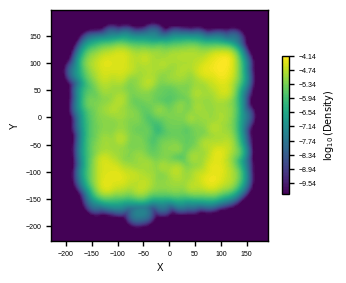

In [137]:
from sklearn.neighbors import KernelDensity
import numpy as np

fig, ax = plt.subplots(1, figsize=(3.5, 3))
kde = KernelDensity(bandwidth=7.5, kernel="gaussian")
kde.fit(xy)

# Evaluate on a grid
buffer = 50
xx, yy = np.meshgrid(
    np.linspace(x.min() - buffer, x.max() + buffer, 100), np.linspace(y.min() - buffer, y.max() + buffer, 100)
)
grid = np.vstack([xx.ravel(), yy.ravel()]).T
zz = np.exp(kde.score_samples(grid)).reshape(xx.shape)
zz_safe = np.clip(zz, 1e-10, None)
plt.contourf(xx, yy, np.log10(zz_safe), levels=100, cmap="viridis")
plt.xlabel("X")
plt.ylabel("Y")
plt.colorbar(label=r"$\log_{10}(\mathrm{Density})$", shrink=0.6)
plt.show()
fig.savefig(os.path.join(fig_dir, "centroid_xy_whole_dataset_pdf.pdf"), dpi=600, bbox_inches="tight")

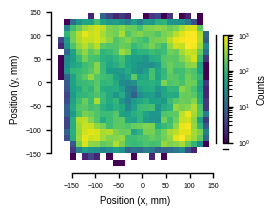

In [140]:
from matplotlib.colors import LogNorm

fig, ax = plt.subplots(1, figsize=(2.5,2))
hb = ax.hist2d(x, y, 
               bins=25, 
               cmap="viridis",
               # vmin=0,
               # vmax=1e4,
               norm=LogNorm(vmin=1, vmax=1e3))
cbar = plt.colorbar(hb[3], ax=ax, shrink=.7, label="Counts")
ax.set_xticks(np.arange(-150,151,50))
ax.set_yticks(np.arange(-150,151,50))
ax.set_xlabel("Position (x, mm)")
ax.set_ylabel("Position (y, mm)")
sns.despine(offset=5, trim=True)
fig.savefig(os.path.join(fig_dir, "centroid_xy_whole_dataset_histogram.pdf"), dpi=600, bbox_inches="tight")